In [1]:
!pip install opendatasets -q

In [2]:
import opendatasets as od
data_url="https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes"
od.download(data_url)

100%|██████████| 309M/309M [00:16<00:00, 20.1MB/s]


In [3]:
root_dir = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/"
train_dir = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train/"
test_dir = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/"

In [4]:
!rm -rf /content/emotion-detection-fer/test/fearful
!rm -rf /content/emotion-detection-fer/test/surprised
!rm -rf /content/emotion-detection-fer/test/angry
!rm -rf /content/emotion-detection-fer/test/disgusted
!rm -rf /content/emotion-detection-fer/train/fearful
!rm -rf /content/emotion-detection-fer/train/surprised
!rm -rf /content/emotion-detection-fer/train/angry
!rm -rf /content/emotion-detection-fer/train/disgusted


In [5]:
import os
target_var = os.listdir(train_dir)
target_var

['sad', 'happy', 'angry']

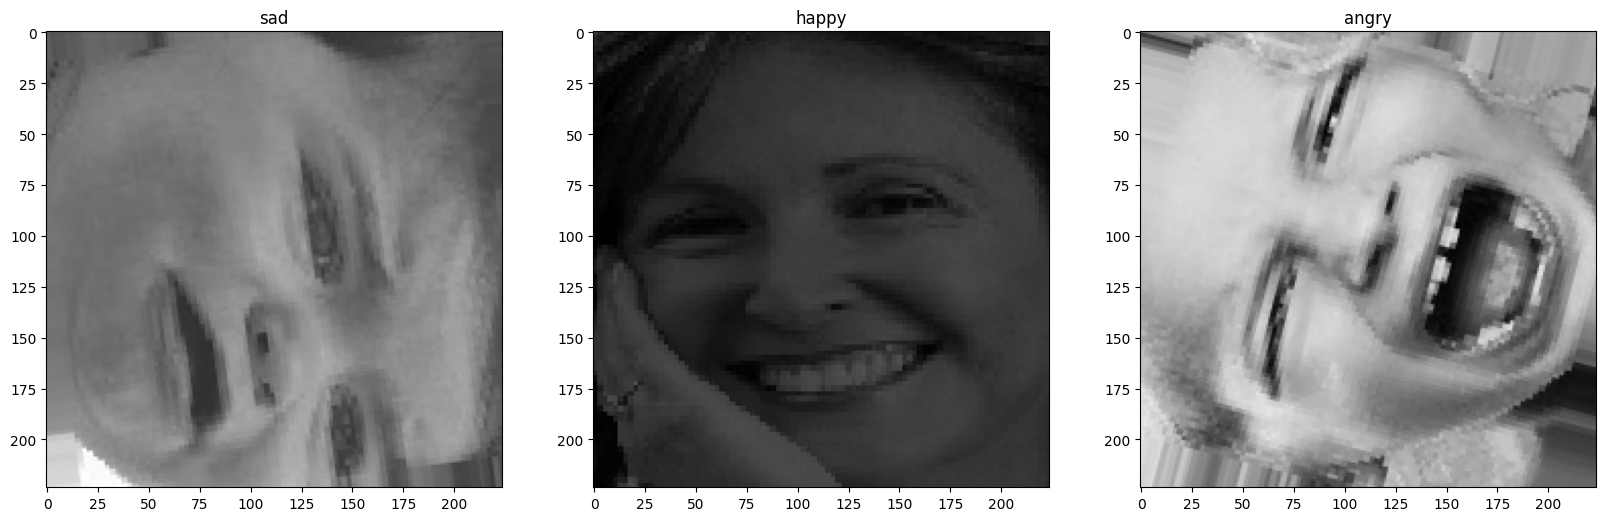

In [6]:
# Sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20,8))
for i in range(len(target_var)):
    d = train_dir+target_var[i]+'/'+os.listdir(train_dir+target_var[i]+'/')[0]
    axes[i].imshow( plt.imread(d) )
    axes[i].set_title(target_var[i])
plt.show()

Emotion :sad
Train :2255
Test :757


Emotion :happy
Train :3019
Test :1006


Emotion :angry
Train :1525
Test :515




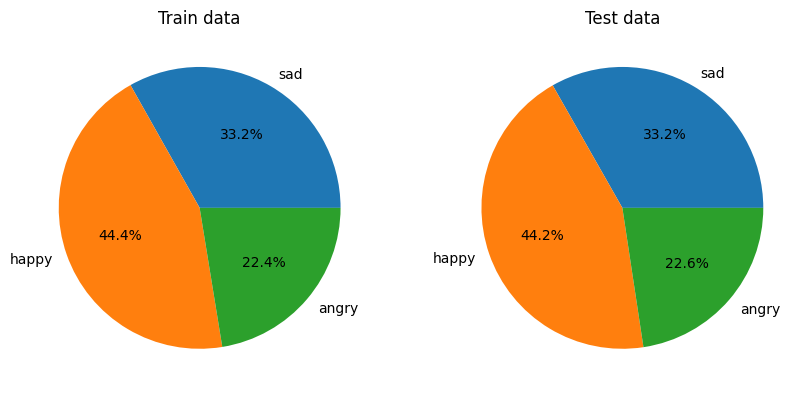

In [7]:
# Exploring the distribution of data
import numpy as np

x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in os.listdir(train_dir)])
x_test = np.array([ len(os.listdir(test_dir+i+'/')) for  i in os.listdir(test_dir)])
label = target_var

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%')
axes[0].set_title("Train data")
axes[1].pie(x_test, labels=label, autopct='%1.1f%%')
axes[1].set_title("Test data");

for i in target_var:
  print(f"Emotion :" + i)
  print(f"Train :"+ str(len(os.listdir(train_dir+i+'/'))))
  print(f"Test :"+ str(len(os.listdir(test_dir+i+'/'))))
  print("\n")

In [8]:
# Data Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_idg = ImageDataGenerator(rescale=1./255 , validation_split=0.3, rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    )

test_idg = ImageDataGenerator(rescale=1./255, rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,)

img_size = (48,48)
batch_size = 32

train_args = {
    'target_size': img_size,
    'batch_size': batch_size,
    'color_mode': 'grayscale',
    'class_mode': 'categorical',
    'shuffle':True
}

test_args = {
    'target_size': img_size,
    'batch_size': batch_size,
    'color_mode': 'grayscale',
    'class_mode': 'categorical',
    'shuffle': False,
}

train = train_idg.flow_from_directory(directory=train_dir, subset='training', **train_args)
valid = train_idg.flow_from_directory(directory=train_dir, subset='validation', **train_args)
test = test_idg.flow_from_directory(directory=test_dir, **test_args)

Found 4761 images belonging to 3 classes.
Found 2038 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.


In [9]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPooling2D, Activation

model = tf.keras.Sequential()

# A single input layer consisting of two consecutive 2D convolutional layers,
# each with 32 filters of size 3x3 and using a rectified linear unit (ReLU) activation function.
# Batch normalization is applied after each convolutional layer to normalize the input to the next layer.
# A max pooling layer with a pool size of 2x2 is used to reduce the spatial dimensions of the output,
# and a dropout layer with a rate of 0.2 is applied to randomly drop 20% of the neurons in the layer during training.

model.add(Conv2D(64,(5,5), padding='same', kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(5,5),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# This is a hidden layer. It consists of two Conv2D layers, each with 64 filters,
# followed by ReLU activation function, BatchNormalization, MaxPooling2D layer
# with a pool size of (2,2), and Dropout regularization with a rate of 0.2.

model.add(Conv2D(128,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# This is a hidden layer. It consists of two Conv2D layers, each with 256 filters,
# followed by ReLU activation function, BatchNormalization, MaxPooling2D layer
# with a pool size of (2,2), and Dropout regularization with a rate of 0.2.

model.add(Conv2D(256,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# This is the output layer with 2 Dense layers of 64 units and a final Dense layer with 7 outputs
model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(3, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [11]:
%time
history = model.fit(train,
          validation_data=valid,
          epochs=100,
          callbacks=[early_stopping, lr_scheduler],
          use_multiprocessing=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs
Epoch 1/100
149/149 [==============================] - 60s 158ms/step - loss: 1.6356 - accuracy: 0.3867 - val_loss: 1.1171 - val_accuracy: 0.4578 - lr: 0.0010
Epoch 2/100
149/149 [==============================] - 22s 149ms/step - loss: 1.3346 - accuracy: 0.4073 - val_loss: 1.0776 - val_accuracy: 0.4637 - lr: 0.0010
Epoch 3/100
149/149 [==============================] - 22s 147ms/step - loss: 1.1618 - accuracy: 0.4402 - val_loss: 1.0251 - val_accuracy: 0.5069 - lr: 0.0010
Epoch 4/100
149/149 [==============================] - 22s 150ms/step - loss: 1.0790 - accuracy: 0.4682 - val_loss: 1.0224 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 5/100
149/149 [==============================] - 22s 149ms/step - loss: 1.0316 - accuracy: 0.4972 - val_loss: 0.9810 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 6/100
149/149 [==============================] - 22s 148ms/step - loss: 1.0092 - accuracy: 0.5060 - val_loss: 0.9962 - val_accuracy: 0.

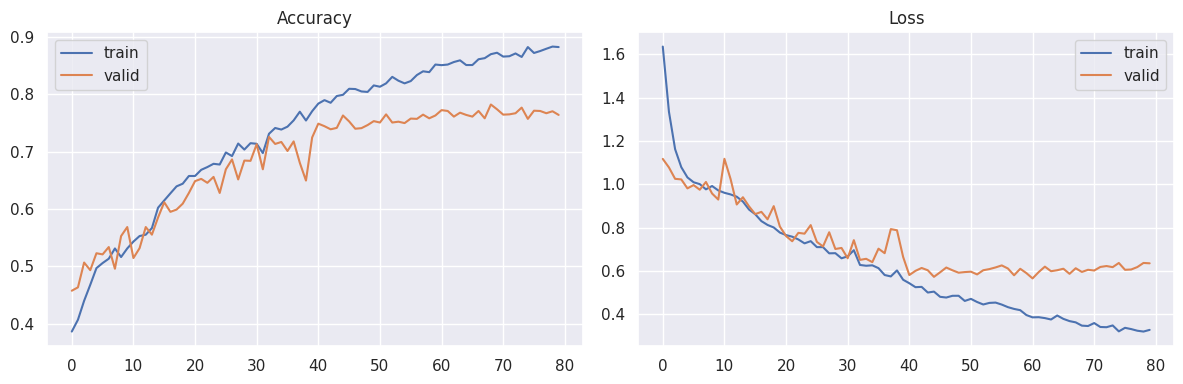

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()


In [ ]:
!cp -r /content/drive/MyDrive/model-min-label.h5 /content


In [ ]:
import tensorflow_hub as hub
model = tf.keras.models.load_model('/content/model-min-label.h5', custom_objects={"KerasLayer":hub.KerasLayer})

In [ ]:
model.save("model-min-label.h5")

In [16]:
# Make predictions
y_pred = model.predict(test)
y_pred

72/72 [==============================] - 5s 60ms/step


array([[0.62521416, 0.06395864, 0.3108272 ],
       [0.10664596, 0.06041107, 0.83294296],
       [0.24702103, 0.21929368, 0.5336853 ],
       ...,
       [0.7906992 , 0.01218139, 0.19711939],
       [0.9296644 , 0.00421425, 0.06612142],
       [0.85205704, 0.02983028, 0.11811268]], dtype=float32)

In [17]:
pred_labels = []
for i in y_pred:
  pred_labels.append((np.argmax(i)))

len(pred_labels)

2278

In [18]:
y_actual = test.classes[test.index_array]
len(y_actual)

2278

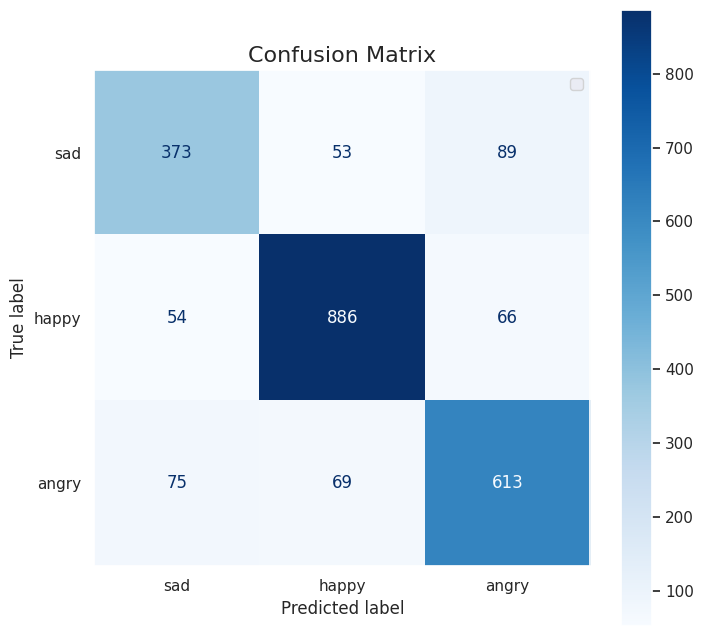

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_actual, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_actual))
fig, ax = plt.subplots(figsize=(8, 8))
im = disp.plot(ax=ax, cmap='Blues')
im.ax_.set_title('Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['sad', 'happy', 'angry']);
ax.yaxis.set_ticklabels(['sad', 'happy', 'angry']);
plt.grid(False)
plt.legend()
plt.show()


In [27]:
acc = np.sum(np.diag(cm)) / np.sum(cm)
print("Test accuracy : ", acc)

Test accuracy :  0.8217734855136084


In [29]:
!cp -r /content/drive/MyDrive/haarcascade_frontalface_default.xml /content

In [30]:
import cv2

# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define a function to preprocess the input image
def preprocess_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image using the Haar Cascade Classifier
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # If no faces are detected, return None
    if len(faces) == 0:
        return None
    # Extract the first face detected (assuming only one face in the image)
    x, y, w, h = faces[0]
    # Crop the image to the face region
    face_roi = gray[y:y+h, x:x+w]
    # Resize the image to the expected input size of the emotion recognition model
    resized = cv2.resize(face_roi, (48, 48), interpolation=cv2.INTER_AREA)
    # Reshape the image to the expected input shape of the emotion recognition model
    reshaped = np.reshape(resized, (1, 48, 48, 1))
    # Normalize the pixel values to the range [0, 1]
    normalized = reshaped / 255.0
    # Return the preprocessed image
    return normalized

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path = "/content/emotion-custom-images/20230501_173222.jpg"
image = cv2.imread(image_path)

preprocessed_image = preprocess_image(image)

prediction_on_img = model.predict(preprocessed_image)
prediction_on_img


1/1 [==============================] - 0s 21ms/step


array([[0.29782003, 0.08413906, 0.6180409 ]], dtype=float32)

In [ ]:
target_var[np.argmax(prediction_on_img)]

'angry'

In [ ]:
custom_dir = "/content/emotion-custom-images/"
predictions=[]

for img in os.listdir(custom_dir):
  image = cv2.imread(os.path.join(custom_dir, img))
  preprocessed_image = preprocess_image(image)

  # if preprocessed_image is None:
  #   print('No faces detected!')
  #   exit()

  predictions.append(model.predict(preprocessed_image))


fig, axes = plt.subplots(2,7, figsize=(20,8))
for i, img in enumerate(os.listdir(custom_dir)):
    d = os.path.join(custom_dir,img)
    axes[i//7, i%7].imshow(plt.imread(d))
    axes[i//7, i%7].set_title(target_var[np.argmax(predictions[i])])
    axes[i//7, i%7].set_xticks([])
    axes[i//7, i%7].set_yticks([])

plt.show()

In [ ]:
!pip install tensorflowjs -q
!tensorflowjs_converter --input_format keras /content/model-min-label.h5 /content/final-min-label-model